### Motion Anomaly Detection

In [1]:
import numpy as np
import sympy as sp
import scipy 
import matplotlib.pyplot as plt
from sympy import Matrix
import cv2
from cv2 import *
from scipy.optimize import least_squares, lsq_linear
import sys
import cma
from sklearn.cluster import KMeans


****************************CLIP***********************************= 1


/home/pranav/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<built-in function phase> 1.0 [4 3]
****************************CLIP***********************************= 2
<built-in function phase> 1.0 [3 3]
****************************CLIP***********************************= 3
<built-in function phase> 1.0 [4 2]
****************************CLIP***********************************= 4
<built-in function phase> 1.0 [3 4]
****************************CLIP***********************************= 5
<built-in function phase> 1.0 [3 4]
****************************CLIP***********************************= 6
<built-in function phase> 1.0 [3 3]
****************************CLIP***********************************= 7
<built-in function phase> 1.0 [3 5]
****************************CLIP***********************************= 8
<built-in function phase> 1.0 [5 2]
****************************CLIP***********************************= 9
****************************CLIP***********************************= 10
****************************CLIP***********************************= 11


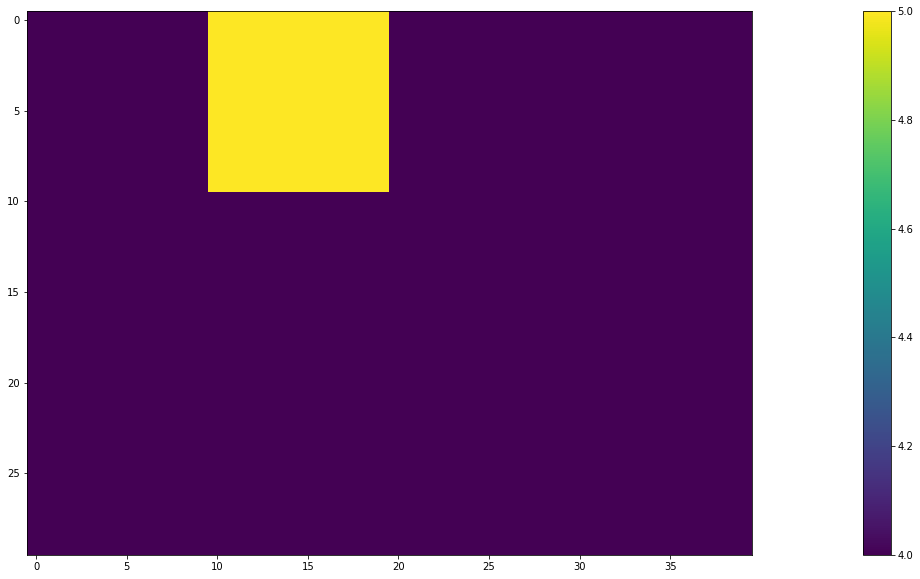

In [21]:
#UMN

#Changes:
# N = 10
# resize(::8,::8)

# Coding
# node=1
# saddle=2
# star=3
# improper=4
# center=5
# spiral=6



# img_path = "/home/pranav/Downloads/RnD/training/image_02/0002_cross/%1d.png"
img_path = "/home/pranav/Downloads/RnD/training/UMN/Crowd-Activity-All .avi"



noise_mean = 0.05
start_frame = 52*30
anomaly_val, phase_map , flow_ret, clip, anom_list = FB_flow(img_path,noise_mean,start_frame)
print anomaly_val
print '************************Phase_map************************', type(phase_map)
plt.imshow(phase_map.T)
plt.colorbar()
plt.savefig('/home/pranav/Downloads/RnD/training/UMN/phase_1_th.png', bbox_inches='tight')
print '****************************CLIP*************************'
print clip
print anom_list

20
20


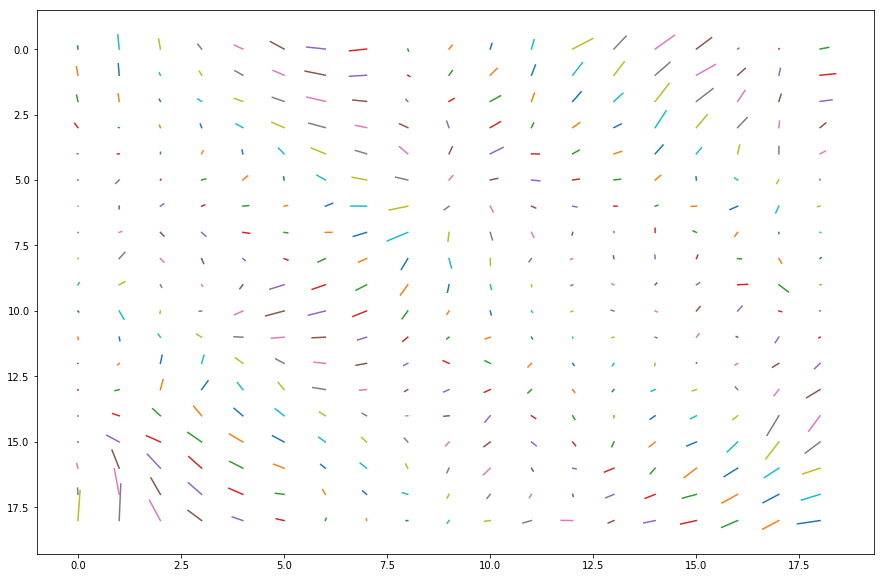

In [18]:
flow_sub = resized_flow(flow_ret)
# flow_sub = flow_sub*0 + 0.0
# flow_sub[:,:,1] +=1
flow_x = np.shape(flow_sub)[0]
flow_y = np.shape(flow_sub)[1]
print flow_x
print flow_y
fig = plt.figure(figsize=(15,10))
for x in range(0,flow_x-1):
    for y in range(0,flow_y-1):
        plt.plot([x,x+flow_sub[x,y,0]/1],[y,y+flow_sub[x,y,1]/1],'-')
        
# plt.plot(centroid_x,centroid_y,'o',label='Predicted Critical Point')
# plt.legend()
# plt.title('Multiple Critical Points')
plt.gca().invert_yaxis()

In [56]:
np.save('anom1_s1_np.npy', anom_list)

with open('anom1_s2.txt', 'w') as f:
    for item in anom_list:
        f.write("%s\n" % item)

[2. 3. 4.]


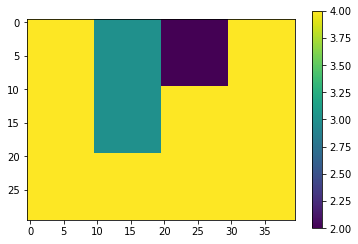

In [25]:
# Coding
# node=1
# saddle=2
# star=3
# improper=4
# center=5
# spiral=6
plt.imshow(phase_map.T)
plt.colorbar()
print np.unique(phase_map)
# plt.savefig('/home/pranav/Downloads/RnD/training/UMN/phase_43_th.png', bbox_inches='tight')
# print phase_map

In [116]:
print np.max(flow_sub)

0.6754819


#### Obtain Dominant(Averaged) Flow

In [19]:
#####################################################################

# Example : perform live visualization of optic flow from a video file
# specified on the command line (e.g. python FILE.py video_file) or from
# an attached web camera

# Author : Toby Breckon, toby.breckon@durham.ac.uk

# Copyright (c) 2017 School of Engineering & Computing Science,
#                    Durham University, UK
# License : LGPL - http://www.gnu.org/licenses/lgpl.html

#####################################################################

import cv2
import sys
import numpy as np
#np.set_printoptions(threshold=np.nan)
#####################################################################



#####################################################################

# draw optic flow visualization on image using a given step size for
# the line glyphs that show the flow vectors on the image

def draw_flow(img, flow, step=4):
    h, w = img.shape[:2]
    #print img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    #print np.shape(flow), np.shape(x), step
    fx, fy = flow[y,x].T
#     print np.shape(fy)
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    #print lines[0][0][0]
#     print (np.shape(fx),np.shape(fy))

#     vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    vis = img
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
#         cv2.circle(vis, (240,320),5,(255,0,0),-1)
    return vis
#     cv2.circle(vis, (200,80),1,(255,0,0),-1)

#####################################################################



# define video capture object

# cap = cv2.VideoCapture();
# cap = cv2.VideoCapture("/home/pranav/Downloads/RnD/manipulator_data/18/images/%1d.jpg")


def FB_flow(image_path,noise_val,start_f):
    N = 10
    anom_list = []
    anomaly_detected = 0
    tot_frame = 10
    keep_processing = True;
    camera_to_use = 0; # 0 if you have one camera, 1 or > 1 otherwise
    clip=0
    prev_anom = 0


    # define display window name


    windowName = "Dense Optic Flow"; # window name
    averageName = 'average'

    # if command line arguments are provided try to read video_name
    # otherwise default to capture from attached H/W camera
    frame_count = 0
    frame_avg_count = 0


    if True :#(((len(sys.argv) == 2) and (cap.open(str(sys.argv[1]))))
    #     or (cap.open(camera_to_use))):
    #     


    #     cap = cv2.VideoCapture("/home/pranav/Downloads/RnD/manipulator_data/16/images/%1d.jpg")
    #     cap = cv2.VideoCapture("/home/pranav/Downloads/RnD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test002/%3d.tif")
    #     cap = cv2.VideoCapture("/home/pranav/Downloads/RnD/training/image_02/0020_overtake/%1d.png")
    #     cap = cv2.VideoCapture("/home/pranav/Downloads/RnD/training/QMUL/qmul_junction.avi")
#         cap = cv2.VideoCapture("/home/pranav/Downloads/RnD/training/image_02/0015_ppl_cross/%1d.png")
        cap = cv2.VideoCapture(image_path)
        f = start_f
        cap.set(1, f)
    #     cap.open('0020.avi')
        # create window by name (as resizable)

        cv2.namedWindow(windowName, cv2.WINDOW_NORMAL);

        # if video file successfully open then read an initial frame from video

        if (cap.isOpened):
            ret, frame = cap.read();

        # convert image to grayscale to be previous frame
        prevgray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        while (keep_processing):

            # if video file successfully open then read frame from video

            if (cap.isOpened):
                ret, frame = cap.read();

                # when we reach the end of the video (file) exit cleanly

                if (ret == 0):
                    keep_processing = False;
                    continue;

            # convert image to grayscale

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # compute dense optic flow using technique of Farneback 2003
            # parameters from example (OpenCV 3.2):
            # https://github.com/opencv/opencv/blob/master/samples/python/opt_flow.py

#             flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)


            frame_count+=1
#             print frame_count
#             curr_flow = flow



            if frame_count ==1:
                flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)  
                flow1= flow

            elif frame_count%tot_frame == 0:
                clip+=1
                print '****************************CLIP***********************************=', clip
                flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)                     
                flow1+=flow
                flow=flow1/(tot_frame)
                cv2.imshow(windowName, draw_flow(frame, flow1))
                flow1 = flow1*0
                avg_flow = resized_flow(flow)
                phase_map, crit_map = scan_ph_crit(avg_flow,noise_val)
#                 return anomaly_detected,phase_map, flow,clip, anom_list
                if clip==1:
                    phase_map_prev = phase_map
                    prev_mean = np.mean(abs(flow))
                    no_zero_mov_prev = np.count_nonzero(phase_map ==4)/ N*N
#                     return anomaly_detected,phase_map, flow,clip,anom_list
                else:
                    
                    ph_diff = phase_map_prev - phase_map
                    curr_mean = np.mean(abs(flow))
                    phase_map_prev = phase_map
                    no_zero_mov = np.count_nonzero(phase_map ==4)/ N*N
                    no_ph_diff = np.count_nonzero(ph_diff)/ (N*N)
                    
                    if (no_ph_diff>7 or   (curr_mean > 1.4*prev_mean and curr_mean>= prev_anom)): # and (abs(no_zero_mov_prev-no_zero_mov) > 2 )) or (no_ph_diff> 5 and (abs(no_zero_mov_prev-no_zero_mov) > 0)):
                        anomaly_detected = 1 - anomaly_detected
                        no_zero_mov_prev = no_zero_mov_prev
                        prev_mean = prev_mean
                        prev_anom = curr_mean
                        
                        print '************ANOMALY ANOMALY ANOMALY ANOMALY DETECTED**************=',clip
                        anom_list.append(clip)

                        key = cv2.waitKey() & 0xFF;
                        if (key == ord('x')):
                            cv2.destroyAllWindows()
                            return anomaly_detected,phase_map, flow,clip, anom_list
                    else:
                        prev_mean = curr_mean
                        prev_anom = 0

                            
#                         return anomaly_detected,phase_map, flow,clip
                                
            else:
                flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)  
                flow1+=flow
            
#            if frame_count%(tot_frame*2) == tot_frame*1 :
            
#             flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
#                 frame_avg_count =1
#     #             seq_count = frame_count
#                 flow1=flow
#     #             frame_count+=1
#     #             frame_count+=0
#             elif frame_avg_count>0 and frame_avg_count <(tot_frame+1):
#                 flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

#                 frame_avg_count +=1
#     #             frame_count+=1
#                 flow1+=flow
#                 if frame_avg_count==tot_frame:
#                     flow=flow1/(tot_frame)
# #                     frame_avg_count=0
#                     cv2.imshow(windowName, draw_flow(frame, flow1))
#                     avg_flow = resized_flow(flow)
#                     phase_map, crit_map = scan_ph_crit(avg_flow)
# #                     plt.imshow(phase_map)
# #                     plt.imshow(crit_map)

# #                     cv2.waitKey()
#                     return anomaly_detected,phase_map, flow

#                     flow1 = flow1*0

#                 if frame_avg_count==tot_frame:
#                     flow=flow1/(tot_frame/2)
# #                     frame_avg_count=0
#                     cv2.imshow(windowName, draw_flow(frame, flow1))
#                     avg_flow = resized_flow(flow)
#                     phase_crit_det(avg_flow)
#                     cv2.waitKey()

#                     cv2.destroyAllWindows()
#                     keep_processing = False


                    
                    
                    
                    
                    
                    
                    

                    
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    

    #             flow1= flow


            #print flow
            prevgray = gray

            # display image with optic flow overlay

#             cv2.imshow(windowName, draw_flow(frame, flow))
    #         prevgray = cv2.Circle(prevgray, (200,80), 1, (255,0,0), thickness=1, lineType=8, shift=0) 
    #         cv2.imshow(windowName, prevgray)


            # start the event loop - essential

            # cv2.waitKey() is a keyboard binding function (argument is the time in milliseconds).
            # It waits for specified milliseconds for any keyboard event.
            # If you press any key in that time, the program continues.
            # If 0 is passed, it waits indefinitely for a key stroke.
            # (bitwise and with 0xFF to extract least significant byte of multi-byte response)

            key = cv2.waitKey(40) & 0xFF; # wait 40ms (i.e. 1000ms / 25 fps = 40 ms)

            # It can also be set to detect specific key strokes by recording which key is pressed

            # e.g. if user presses "x" then exit

            if (key == ord('x')):
                cv2.destroyAllWindows()
                keep_processing = False;

        # close all windows



    else:
        print("No video file specified or camera connected.");

    return anomaly_detected,phase_map, flow


####################################################################################################
    
    
    

#### Resized Average Image

In [4]:
########################## Get Resized Image #######################################################
def resized_flow(flow):
    
#     print np.shape(flow)
    h = np.shape(flow)[0]
    w = np.shape(flow)[1]
    step = 5
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
#     print len(y),len(x)
    #print np.shape(flow), np.shape(x), step
    fx, fy = flow[y,x].T
    flow_sub = flow[y,x]

    # flow_sub =  flow[::25,::35,:]
    # flow_sub =  flow[::17,::57,:] #works_1
    # flow_sub =  flow[::3,::10,:] #nice_1
    flow_sub =  flow[::8,::8,:]
    X_dash = np.transpose(flow_sub, (1, 0, 2))
#     print np.shape(fx)
#     print np.shape(flow_sub)
    # X_dash = flow_sub
#     print np.shape(X_dash)
    # plt.imshow(flow_sub)
#     print 'Resizing, and returning', np.shape(X_dash)
    return X_dash
    


#### Scan - Phase and Critical Point

In [5]:
def scan_ph_crit(avg_flow,noise_m):
#     print 'Entered Scanning'
    node=1
    saddle=2
    star=3
    improper=4
    center=5
    spiral=6

    # root1 = A_eig[0]
    # root2 = A_eig[1]
    # l_1 = J[0,0]
    # l_2 = J[1,1]
    # imp = J[0,1]

    dom_image = avg_flow
    
    domin_r_1 = []
    domin_theta_1 =[]
    flow_x = np.shape(dom_image)[0]
    flow_y = np.shape(dom_image)[1]
    w_size = 10

    n_windows_x = flow_x/w_size
    n_windows_y = flow_y/w_size
    fit_map = np.zeros((flow_x,flow_y))

    N=w_size

    # from scipy.optimize import least_squares
    fit = np.zeros((n_windows_x,n_windows_y))
    x_zerolist = [] #np.zeros((2,2))
    x_zerolist_all = []
    
    fixed_map = np.zeros((flow_x,flow_y))
    wind_no = 0
    import time
    start = time.clock()
    for xx in range(0,n_windows_x):
        for yy in range(0,n_windows_y):
            wind_no+=1
            flow_man = dom_image[0+xx*w_size:w_size+xx*w_size,0+yy*w_size:w_size+yy*w_size,:] +0.00001
            flow1 = flow_man
#             print 'In the window number', wind_no, ' out of windows ',n_windows_x,',',n_windows_y,'...'
            if (np.mean(abs(flow1))) < noise_m: # and np.sum(abs(flow1)) < 12.:
                fit_map[ 0+xx*w_size:w_size+xx*w_size,0+yy*w_size:w_size+yy*w_size] = 4   
            else:
                

                orient,clust_image = cluster_sample(flow1)

                omega = fit_lines(flow1,orient,clust_image)

                crit_init = [0,0]
                crit_opt= scipy.optimize.minimize(crit_lms,crit_init,omega)
                cp = crit_opt.x

                phase_no = phase_class(cp,flow1)



                #Assigning Phase-number  
#                 if (np.mean(abs(flow1))) < 0.5: # and np.sum(abs(flow1)) < 12.:
#                     fit_map[ 0+xx*w_size:w_size+xx*w_size,0+yy*w_size:w_size+yy*w_size] = 4   
#                 else:
                fit_map[ 0+xx*w_size:w_size+xx*w_size,0+yy*w_size:w_size+yy*w_size] = phase_no   


                #Calculating Fitness(closeness between predicted and actual)
    #             fit[xx,yy]=1 - sum_of_areas(res_1.x)/(w_size**2/2)
                fit[xx,yy] = 1

                #Assigning Critical Point
    #             x_zero1 = (np.around(x_zero))
                x_zero1 = cp


                x_zero1 = x_zero1.astype(int)
                if x_zero1[0]+xx*w_size>N*2 or x_zero1[0]+xx*w_size <0 or x_zero1[1]+yy*w_size> N*2 or x_zero1[1]+yy*w_size<0:
        #             x_zero_1[0] = 0
        #             x_zero1[1] = 0
        #             fixed_map[x_zero1[0]+xx*11,x_zero1[1]+yy*11]= fit[xx,yy]
                    x_zerolist_all.append(x_zero1)
    #                 print phase
    #                 pass
                else:
                    x_zerolist_all.append(x_zero1)
                    x_zerolist.append(x_zero1)
                    print phase,fit[xx,yy],x_zero1
                    fixed_map[x_zero1[0]+xx*w_size,x_zero1[1]+yy*w_size]= fit[xx,yy]


            # print np.shape(x_zero1)

#     print time.clock()- start
#     print 'Returning Scanned data, phase map, critical point map..'
    return fit_map, fixed_map

#### Orientation Image

In [6]:
def orientation_image(flow1): 
    N =10
    r_1 =np.zeros((N,N))
    r_2 = np.zeros((N,N))
    theta_1 = np.zeros((N,N))
    theta_sin = np.zeros((N,N))
    theta_cos = np.zeros((N,N))
     
    for i in range (0,N):
        for j in range (0,N):
            pos = np.array([i,j]).T
            r_1[i,j] = np.sqrt(flow1[i][j][0]**2+flow1[i][j][1]**2)
            theta_1 [i,j]= np.arctan(flow1[i][j][1]/flow1[i][j][0])
            theta_sin[i,j] = (r_1[i,j]**2)*np.sin(2*theta_1[i,j])
            theta_cos[i,j] = (r_1[i,j]**2)*np.cos(2*theta_1[i,j])
    
    return theta_1

#### Clustering - Sampling

In [7]:
def cluster_sample(flow_man):
#     print 'Entered Clustering'
    X_dash = flow_man
    xx=yy=0
    step_N = 10
    X_dash_sect = X_dash[0+xx*step_N:step_N+xx*step_N,0+yy*step_N:step_N+yy*step_N,:] +0.00001
    flow1=X_dash_sect
    k = 0.17
    orient = (orientation_image(flow1))
    n= 3.14/(0.17/2)
    orient = orient*180/3.14
    orient =  (orient).astype(int)
    # for x in orient:
    #     x= [y+180 for y in x if y<0]
    # [y+180 for y in orient[:,] if y<0]

    for i in range(orient.shape[0]):
        for j in range (orient.shape[1]):
            if orient[i,j]<0:
                orient[i,j]+=180
    # orient = orient*3.14/180
#     print np.min(orient)
#     print np.max(orient)
    clust_full =[]
    clust_image = np.zeros((step_N,step_N))
    for i in range (int(n)):
        thet_start =  0.0 +i*3
        thet_end = thet_start + 3
    #     print  thet_start, thet_end
    #     orient_loc_st = np.where(orient>70)
    #     orient_loc_end = np.where(orient<80)
        clust_section = []
        for x in range(0,step_N):
            for y in range(step_N):
                if orient[x,y]>=thet_start and orient[x,y]<thet_end :
                    clust_section.append((x,y))
                    clust_image[x,y] = i
        clust_full.append(clust_section)
    #     x_points = set(orient_loc_st).intersection(orient_loc_end)
    # print orient_loc_st[0]
    # print orient_loc_end[0]
    # print x_points
    # print clust_section
    
#Uncomment for plots    
#     plt.imshow(clust_image.T)
#     plt.colorbar()
#     print 'Leaving Clustering'
    return orient, clust_image
    
    # plt.ylim(0,21)

#### LMS

In [8]:
def lms(para,x,y,zet):
    return np.mean(np.square(np.cos(para[0])*x + np.sin(para[0])*y + (para[1]) ))
#     return 1/2 *np.sum((np.square(np.cos(para[0])*x + np.sin(para[0])*y + (para[1]) )))
#  return np.median(np.square(para[0]*x + para[1]*y + para[2])) # + 1*np.abs( np.square(para[0])+np.square(para[1])-1)))


#### Line Fitting

In [9]:
def fit_lines(flow,orient, clust_image):
#     print 'In Line Fitting'
    X_dash = flow
    import time
    start = time.clock()

    np.set_printoptions(threshold=np.nan)
    fig = plt.figure(figsize=(40,10))
    xx=0
    yy=0
    step_N = 10
    X_dash_sect = X_dash[0+xx*step_N:step_N+xx*step_N,0+yy*step_N:step_N+yy*step_N,:] +0.00001
    flow1=X_dash_sect

    orient_1 = orient*3.14/180

    orient_1d = orient_1.flatten()
#     print np.max(orient_1d)
#     print orient_1d.shape
    X_dash_1d = orient_1d


    X_dash_2d = X_dash_1d.reshape(step_N,step_N)
    X_dash_1d_sh = X_dash_1d.reshape(-1,1)
#     print X_dash_1d_sh.shape

    no_of_clust = 18

    clust_pred = clust_image.flatten()

    clust_pred_2d = clust_image

    #Uncomment for plots
#     plt.imshow(clust_pred_2d)
#     plt.gca().invert_yaxis()
#     plt.colorbar(fraction=0.025, pad=0.04)

    # print clust_pred
    clusts_uniq = np.unique(clust_pred)

#     print len(clusts_uniq)
    para = [0,0]
    omega = [] 
    tans = []
    mean_tans = []
    e=[]
    f=[]
    mean_lms = []
    for i,val in enumerate(clusts_uniq):
    #     print i
        clusts_loc = np.where(clust_pred_2d==val)
        mean_tans.append(abs(np.mean((orient_1[clusts_loc]))))
        check = (np.mean((orient_1[clusts_loc])))
    #     print 'c',check
        zeta_clust = np.tan(np.mean((orient_1[clusts_loc])))
    #     print zeta_clust
    #     tans.append(np.tan(orient[clusts_loc]))
    #     print clusts_loc
    #     print clusts_loc[0]
        x_points = clusts_loc[0][np.newaxis].T
        y_points = clusts_loc[1][np.newaxis]

    #     lms_val = lms(para,x_points,y_points.T) 
    #     print lms_val
    #     lms_opt = scipy.optimize.least_squares(lms,para,loss='soft_l1', f_scale=0.1,args=(x_points, y_points.T,zeta_clust))
        lms_opt = scipy.optimize.minimize(lms,para,args=(x_points, y_points.T,zeta_clust))
        mean_lms.append(lms_opt.fun)


    #     print lms_opt.fun
    #     print lms_opt.x
        p= lms_opt.x 
    #     print (p)
    #     e.append(p[1])
    #     f.append(p[2])
    #     omega.append(lms_opt.x)
        ones_ar = np.ones((x_points.shape[0],1))
        x_points_ar = np.hstack((x_points,ones_ar))
    #     p = np.linalg.pinv(x_points_ar).dot(y_points.T)
        if  len(orient_1[clusts_loc])>1 : #and (lms_opt.fun) < np.std(mean_lms) +2 : #and ((check>0.3 and check<1.3) or (check>1.8 and check<2.8) or (check>3.4 and check<4.5) or (check > 4.9 and check<6.1)): 
            omega.append([np.cos(p[0]),np.sin(p[0]),p[1]])
    #         print 'orient', (orient_1[clusts_loc])
            tans.append((orient_1[clusts_loc]))
            mean_lms.append(lms_opt.fun)
    #         e.append(p[1])
    #         f.append(p[2])

    #         print 'mean', lms_opt.fun
    #         print 'alpha',np.cos(p[0]),'beta', np.sin(p[0])
    #         print 'tans', np.mean(orient_1[clusts_loc])
    #         print 'line'

    #     print omega
    #     p= lms_opt.x 
    #     print p[0],p[1] 
    #     print x_points.shape, y_points.shape, x_points_ar.shape 
            x_plot = np.arange(0,30)
#Uncomment For Plots
#             plt.plot(x_points, -(np.cos(p[0])*x_points + (p[1]) )/np.sin(p[0]))


#     print time.clock() - start
#     print 'Exiting Line Fitting'
    return omega

#### Critical Point -LMS

In [10]:
def crit_lms(crit_point,omega):
    omega_1= np.array(omega).reshape(-1,3)
    crit_point_1=np.array([crit_point[0],crit_point[1],1])
    mse =  np.square(omega_1.dot(crit_point_1)/np.sqrt((omega_1[:,0]*omega_1[:,0] + omega_1[:,1]*omega_1[:,1])))
    med_val =  np.mean(np.square(omega_1.dot(crit_point_1)/np.sqrt(list(omega_1[:,0]*omega_1[:,0] + omega_1[:,1]*omega_1[:,1]))))
#     print mse
    
    return med_val


#### Phase_Classification

In [11]:
def phase_class(critical_pt,flow):
#     print 'Entering Phase for window'
    X_dash = flow
    cp = critical_pt
    
    N =10
    flow1 = X_dash[:,:,:]
    cp = cp.astype(int)
    x_pos, y_pos = np.mgrid[-cp[0]:-cp[0]+N,-cp[1]:-cp[1]+N]
    # print 
    x_i = x_pos.flatten()[np.newaxis].T
    # print x_i
    y_i = y_pos.flatten()[np.newaxis].T
    # print y_i
    pos_ar = np.hstack((x_i,y_i))
    # print np.shape(pos_ar)


    flow_dx_orig = flow1[:,:,0].reshape(-1,)
    flow_dy_orig = flow1[:,:,1].reshape(-1,)
    # print np.shape(flow_dx_orig)
    flow_dx_dy = np.vstack((flow_dx_orig,flow_dy_orig)).T
#     print np.shape(pos_ar)
#     print np.shape(flow_dx_dy)

    import time
    start = time.clock()
    res_tot = np.linalg.lstsq(pos_ar, flow_dx_dy)
#     print np.shape(res_tot)
#     print res_tot[0]
    eigval_pr, eigvec_pr = np.linalg.eig(res_tot[0])
#     print 'Predicted Eigen Values:',eigval_pr
#     print 'Time taken for classification:',time.clock() - start,'seconds'


    x0 = np.array([[0.5],[0.5]])

    # flow_pred_dx = pos_ar.dot(x0)
    # print flow_pred_dx.shape
    # dx_diff = abs(flow_pred_dx - flow_dx_orig)....
    # print dx_diff.shape
    # total_diff = np.sum(dx_diff)
    # total_diff


    import time
    start = time.clock()


    res_1 = lsq_linear(pos_ar, flow_dx_orig,lsmr_tol='auto') #, bounds=(lb, ub), lsmr_tol='auto')
    # print res_1.x
    a_up = res_1.x


    res_2 = lsq_linear(pos_ar, flow_dy_orig,lsmr_tol='auto') #, bounds=(lb, ub), lsmr_tol='auto')
    # print res_2.x
    a_down = res_2.x


    A_pred  = np.vstack((a_up,a_down))
    eigval_pr, eigvec_pr = np.linalg.eig(A_pred)
#     print 'Predicted Eigen Values:',eigval_pr


#     print 'Time taken for classification:',time.clock() - start,'seconds'


    #### Classification
    m = Matrix(A_pred)
    P, J = m.jordan_form()
#     print 'Jordan'
#     print J


    # fit_map = np.zeros((22,22))

    node=1
    saddle=2
    star=3
    improper=4
    center=5
    spiral=6



    root1 = eigval_pr[0]
    # print root1
    root2 = eigval_pr[1]
    l_1 = J[0,0]
    l_2 = J[1,1]
    imp = J[0,1]
    xx=0
    yy=0



    if isinstance(root1,complex):
        alpha = root1.real
        if abs(alpha)<2e-1:
            phase= 'Center'
            phase_no =  center
    #       fit_map[0+xx*11:11+xx*11 , 0+yy*11:11+yy*11]
        else:
            phase = 'Spiral'
            phase_no =  spiral
    elif ((np.sign(l_1)==np.sign(l_2)) and (abs(abs(l_1)-abs(l_2))<= 9e-1)):
        if (1-imp)<0.1:
            phase = 'Imroper'
            phase_no = imroper
        else:
            phase = 'Star'
            phase_no = star


    #       fit_map[0+xx*11:11+xx*11 , 0+yy*11:11+yy*11] = star
    #       print fit_map

    elif (abs(abs(l_1)-abs(l_2))>9e-1) and (np.sign(l_1)==np.sign(l_2)):
        phase = 'Node'
        phase_no = node

    elif ((np.sign(l_1)!=np.sign(l_2))):
        phase = 'Saddle'
        phase_no = saddle

#     print '*************Phase Portrait Classification*******************'

#     print 'Type:' , phase
    
    
#     print 'Leaving Phase for a window, phase number', phase_no
#     print J
#     print '*********'
    return  phase_no



